# 视频 API

本示例展示了 torchvision 为视频提供的一些 API，以及如何构建数据集等的示例。

## 介绍：构建新的视频对象并检查其属性

首先选择视频来测试对象。为了便于讨论，使用 kinetics400 数据集中的视频。要创建它，需要定义路径和要使用的流。

选择的视频统计信息：

- WUzgd7C1pWA.mp4
    - source:
        - kinetics-400
    - video:
        - H-264
        - MPEG-4 AVC (part 10) (avc1)
        - fps: 29.97
    - audio:
        - MPEG AAC audio (mp4a)
        - sample rate: 48K Hz




In [1]:
from set_env import temp_dir

项目根目录：/media/pc/data/lxw/ai/torch-book


In [2]:
import torch
import torchvision
from torchvision.datasets.utils import download_url
torchvision.set_video_backend("video_reader")

# Download the sample video
download_url(
    "https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/test/assets/videos/WUzgd7C1pWA.mp4",
    temp_dir,
    "WUzgd7C1pWA.mp4"
)
video_path = f"{temp_dir}/WUzgd7C1pWA.mp4"

100%|██████████| 890k/890k [00:00<00:00, 1.05MB/s]


流以类似于 torch 设备的方式定义。我们将它们编码为 ``stream_type:stream_id`` 形式的字符串，其中 ``stream_type`` 是字符串，``stream_id`` 是长整数。构造函数接受仅传递 ``stream_type``，在这种情况下，流会自动发现。首先，让我们获取特定视频的元数据：

In [3]:
stream = "video"
video = torchvision.io.VideoReader(video_path, stream)
video.get_metadata()

{'video': {'duration': [10.9109], 'fps': [29.97002997002997]},
 'audio': {'duration': [10.9], 'framerate': [48000.0]},
 'subtitles': {'duration': []},
 'cc': {'duration': []}}

在这里可以看到视频有两个流 - 一个视频流和一个音频流。目前可用的流类型包括 `['video', 'audio']`。每个描述符由两部分组成：流类型（例如 `'video'`）和唯一的流 ID（由视频编码确定）。通过这种方式，如果视频容器包含多个相同类型的流，用户可以访问他们想要的流。如果仅传递流类型，解码器会自动检测该类型的第一个流并返回它。

读取视频流中的所有帧。默认情况下，``next(video_reader)`` 的返回值是一个包含以下字段的字典。

返回字段是：

- ``data``：包含一个 torch.tensor
- ``pts``：包含此特定帧的浮点时间戳

In [4]:
metadata = video.get_metadata()
video.set_current_stream("audio")

frames = []  # we are going to save the frames here.
ptss = []  # pts is a presentation timestamp in seconds (float) of each frame
for frame in video:
    frames.append(frame['data'])
    ptss.append(frame['pts'])

print("PTS for first five frames ", ptss[:5])
print("Total number of frames: ", len(frames))
approx_nf = metadata['audio']['duration'][0] * metadata['audio']['framerate'][0]
print("Approx total number of datapoints we can expect: ", approx_nf)
print("Read data size: ", frames[0].size(0) * len(frames))

PTS for first five frames  [0.0, 0.021332999999999998, 0.042667, 0.064, 0.08533299999999999]
Total number of frames:  511
Approx total number of datapoints we can expect:  523200.0
Read data size:  523264


但如果只想读取视频的特定时间段呢？这可以通过结合我们的 ``seek`` 函数和每次调用 next 返回的帧的呈现时间戳（以秒为单位）来轻松完成。

鉴于实现依赖于 Python 迭代器，可以利用 itertools 来简化过程并使其更具 Python 风格。

例如，如果想从第二秒开始读取十帧：

In [5]:
import itertools
video.set_current_stream("video")

frames = []  # we are going to save the frames here.

# We seek into a second second of the video and use islice to get 10 frames since
for frame, pts in itertools.islice(video.seek(2), 10):
    frames.append(frame)

print("Total number of frames: ", len(frames))

Total number of frames:  10


或者如果想从第二秒到第五秒读取，我们定位到视频的第二秒，然后我们利用 itertools takewhile 来获取正确数量的帧：

In [6]:
video.set_current_stream("video")
frames = []  # we are going to save the frames here.
video = video.seek(2)

for frame in itertools.takewhile(lambda x: x['pts'] <= 5, video):
    frames.append(frame['data'])

print("Total number of frames: ", len(frames))
approx_nf = (5 - 2) * video.get_metadata()['video']['fps'][0]
print("We can expect approx: ", approx_nf)
print("Tensor size: ", frames[0].size())

Total number of frames:  90
We can expect approx:  89.91008991008991
Tensor size:  torch.Size([3, 256, 340])


## 构建示例 read_video 函数

可以利用上述方法来构建遵循与现有 ``read_video`` 函数相同 API 的 read_video 函数。

In [7]:
def example_read_video(video_object, start=0, end=None, read_video=True, read_audio=True):
    if end is None:
        end = float("inf")
    if end < start:
        raise ValueError(
            "end time should be larger than start time, got "
            f"start time={start} and end time={end}"
        )

    video_frames = torch.empty(0)
    video_pts = []
    if read_video:
        video_object.set_current_stream("video")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            video_pts.append(frame['pts'])
        if len(frames) > 0:
            video_frames = torch.stack(frames, 0)

    audio_frames = torch.empty(0)
    audio_pts = []
    if read_audio:
        video_object.set_current_stream("audio")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            audio_pts.append(frame['pts'])
        if len(frames) > 0:
            audio_frames = torch.cat(frames, 0)

    return video_frames, audio_frames, (video_pts, audio_pts), video_object.get_metadata()


# Total number of frames should be 327 for video and 523264 datapoints for audio
vf, af, info, meta = example_read_video(video)
print(vf.size(), af.size())

torch.Size([327, 3, 256, 340]) torch.Size([523264, 1])


## 3. 构建示例随机采样数据集（可应用于 kinetics400 的训练数据集）

酷，现在可以使用相同的原则来制作样本数据集。我们建议为此目的尝试可迭代数据集。在这里，将构建示例数据集，读取随机选择的 10 帧视频。

制作样本数据集:

In [ ]:
(temp_dir/"./dataset").mkdir(exist_ok=True)
(temp_dir/"./dataset/1").mkdir(exist_ok=True)
(temp_dir/"./dataset/2").mkdir(exist_ok=True)

下载视频：

In [9]:
from torchvision.datasets.utils import download_url
root_url = "https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/test/assets/videos"
download_url(
    f"{root_url}/WUzgd7C1pWA.mp4?raw=true",
    temp_dir/"./dataset/1", "WUzgd7C1pWA.mp4"
)
download_url(
    f"{root_url}/RATRACE_wave_f_nm_np1_fr_goo_37.avi?raw=true",
    temp_dir/"./dataset/1",
    "RATRACE_wave_f_nm_np1_fr_goo_37.avi"
)
download_url(
    f"{root_url}/SOX5yA1l24A.mp4?raw=true",
    temp_dir/"./dataset/2",
    "SOX5yA1l24A.mp4"
)
download_url(
    f"{root_url}/v_SoccerJuggling_g23_c01.avi?raw=true",
    temp_dir/"./dataset/2",
    "v_SoccerJuggling_g23_c01.avi"
)
download_url(
    f"{root_url}/v_SoccerJuggling_g24_c01.avi?raw=true",
    temp_dir/"./dataset/2",
    "v_SoccerJuggling_g24_c01.avi"
)

100%|██████████| 890k/890k [00:00<00:00, 1.17MB/s]


100%|██████████| 264k/264k [00:00<00:00, 608kB/s] 


100%|██████████| 560k/560k [00:00<00:00, 1.41MB/s]


100%|██████████| 508k/508k [00:00<00:00, 1.44MB/s]


100%|██████████| 623k/623k [00:00<00:00, 711kB/s] 


家政服务与公共事业：

In [10]:
import os
import random

from torchvision.datasets.folder import make_dataset
from torchvision import transforms as t


def _find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


def get_samples(root, extensions=(".mp4", ".avi")):
    _, class_to_idx = _find_classes(root)
    return make_dataset(root, class_to_idx, extensions=extensions)

定义数据集和一些基本参数。假设 FolderDataset 的结构，并添加以下参数：

- ``clip_len``：剪辑的帧长度
- ``frame_transform``：每个帧的变换
- ``video_transform``：视频序列的变换

```{note}
:class: alert alert-info
实际上添加了 epoch 大小，因为使用 {func}`~torch.utils.data.IterableDataset` 类允许我们根据需要从每个视频中自然地过度采样剪辑或图像。
```

In [11]:
class RandomDataset(torch.utils.data.IterableDataset):
    def __init__(self, root, epoch_size=None, frame_transform=None, video_transform=None, clip_len=16):
        super(RandomDataset).__init__()

        self.samples = get_samples(root)

        # Allow for temporal jittering
        if epoch_size is None:
            epoch_size = len(self.samples)
        self.epoch_size = epoch_size

        self.clip_len = clip_len
        self.frame_transform = frame_transform
        self.video_transform = video_transform

    def __iter__(self):
        for i in range(self.epoch_size):
            # Get random sample
            path, target = random.choice(self.samples)
            # Get video object
            vid = torchvision.io.VideoReader(path, "video")
            metadata = vid.get_metadata()
            video_frames = []  # video frame buffer

            # Seek and return frames
            max_seek = metadata["video"]['duration'][0] - (self.clip_len / metadata["video"]['fps'][0])
            start = random.uniform(0., max_seek)
            for frame in itertools.islice(vid.seek(start), self.clip_len):
                video_frames.append(self.frame_transform(frame['data']))
                current_pts = frame['pts']
            # Stack it into a tensor
            video = torch.stack(video_frames, 0)
            if self.video_transform:
                video = self.video_transform(video)
            output = {
                'path': path,
                'video': video,
                'target': target,
                'start': start,
                'end': current_pts}
            yield output

给定文件夹结构中的视频路径，即：

- dataset
    - class 1
        - file 0
        - file 1
        - ...
    - class 2
        - file 0
        - file 1
        - ...
    - ...


可以生成数据加载器并测试数据集。

In [12]:
transforms = [t.Resize((112, 112))]
frame_transform = t.Compose(transforms)

dataset = RandomDataset(f"{temp_dir}/dataset", epoch_size=None, frame_transform=frame_transform)

In [13]:
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=12)
data = {"video": [], 'start': [], 'end': [], 'tensorsize': []}
for batch in loader:
    for i in range(len(batch['path'])):
        data['video'].append(batch['path'][i])
        data['start'].append(batch['start'][i].item())
        data['end'].append(batch['end'][i].item())
        data['tensorsize'].append(batch['video'][i].size())
print(data)

{'video': ['/media/pc/data/lxw/ai/torch-book/tests/.temp/tasks/dataset/2/SOX5yA1l24A.mp4', '/media/pc/data/lxw/ai/torch-book/tests/.temp/tasks/dataset/2/v_SoccerJuggling_g24_c01.avi', '/media/pc/data/lxw/ai/torch-book/tests/.temp/tasks/dataset/1/RATRACE_wave_f_nm_np1_fr_goo_37.avi', '/media/pc/data/lxw/ai/torch-book/tests/.temp/tasks/dataset/2/v_SoccerJuggling_g23_c01.avi', '/media/pc/data/lxw/ai/torch-book/tests/.temp/tasks/dataset/1/RATRACE_wave_f_nm_np1_fr_goo_37.avi'], 'start': [5.627342589083136, 5.1310869183540735, 0.11882101882870964, 4.3466401676540025, 0.8623983005356067], 'end': [6.139467, 5.638967, 0.6333329999999999, 4.8715329999999994, 1.3666669999999999], 'tensorsize': [torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112])]}


## 数据可视化

可视化视频的示例

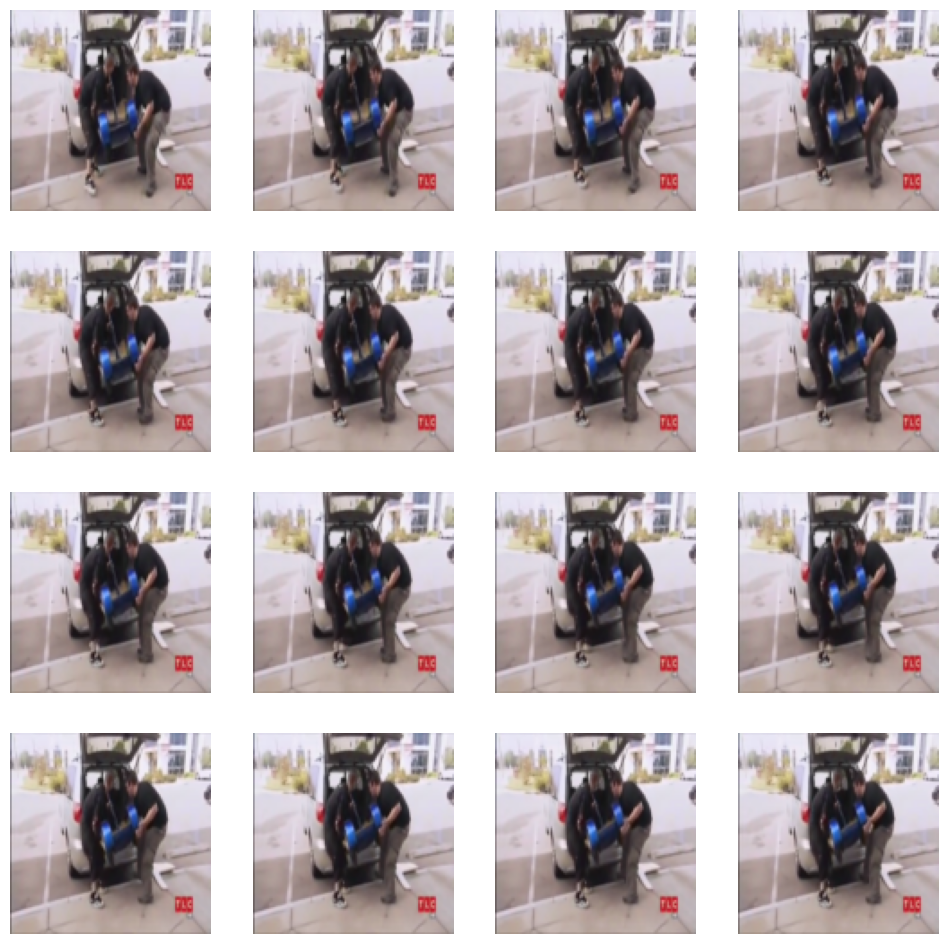

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(batch["video"][0, i, ...].permute(1, 2, 0))
    plt.axis("off")

清理视频和数据集：

In [ ]:
import os
import shutil
os.remove(temp_dir/"./WUzgd7C1pWA.mp4")
shutil.rmtree(temp_dir/"./dataset")